# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [2]:
df_train = pd.read_csv("../../../datasets/competencia3_2022.csv")

C:\Users\programadorweb4\AppData\Local\Temp\ipykernel_34268\2136289393.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../../../datasets/competencia3_2022.csv")


In [3]:
Xtrain = df_train[df_train["foto_mes"] == 202105]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [4]:
Xbajas = df_train.query("foto_mes == 202105 and clase_ternaria != 'CONTINUA'")

In [5]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xbajas.shape)

(163768, 155)
(163768,)
(2013, 155)


Y nos deshacemos del target y limpiamos un poco la memoria.

In [6]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

## Hacemos un modelo **LGBM**

In [7]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Importancia de variables

In [8]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
153,Visa_mpagominimo,144
52,mpayroll,130
8,mrentabilidad_annual,125
107,ctrx_quarter,109
22,mcuentas_saldo,87
...,...,...
87,mcheques_depositados,0
86,ccheques_depositados,0
38,cplazo_fijo,0
79,mforex_sell,0


## Obtenemos shap values

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [9]:
import shap

In [10]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [11]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,0.012060,0.0,0.0,0.0,-0.004652,-0.035978,0.014028,-0.048125,0.118778,0.001401,...,0.0,-0.022071,-0.000871,-0.009556,-0.001845,0.005943,0.0,0.003621,0.0,-0.122924
1,0.011711,0.0,0.0,0.0,-0.003884,-0.012082,0.008283,-0.042697,0.028344,0.004609,...,0.0,-0.022857,-0.001105,-0.007734,-0.009971,-0.016596,0.0,-0.001598,0.0,-0.148640
2,0.029624,0.0,0.0,0.0,-0.003133,-0.056015,-0.004889,0.026270,-0.294516,-0.000341,...,0.0,-0.005882,0.004929,0.018238,-0.005103,-0.020349,0.0,-0.046328,0.0,0.082311
3,0.016379,0.0,0.0,0.0,-0.002641,-0.026413,0.003960,0.024393,-0.002823,0.002876,...,0.0,-0.028704,0.007929,0.014220,0.000317,-0.025527,0.0,-0.039198,0.0,0.098258
4,0.010660,0.0,0.0,0.0,-0.003027,-0.009439,-0.018790,-0.037290,0.103619,0.003166,...,0.0,0.010070,-0.000961,-0.009740,-0.001661,-0.010833,0.0,-0.004043,0.0,-0.252880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,-0.017580,0.0,0.0,0.0,-0.002668,0.053268,0.013337,0.059256,-0.188708,-0.006593,...,0.0,-0.001974,-0.004066,-0.020409,0.000298,0.039347,0.0,0.096643,0.0,-0.059117
2009,-0.021045,0.0,0.0,0.0,-0.003195,-0.016500,0.003599,0.065780,-0.147748,-0.008972,...,0.0,0.001946,-0.001296,-0.015352,-0.001403,0.054760,0.0,0.013483,0.0,-0.182111
2010,-0.020107,0.0,0.0,0.0,-0.003639,-0.103713,-0.001570,0.061462,-0.154107,-0.015984,...,0.0,-0.000049,-0.001684,-0.009872,-0.001738,0.062567,0.0,0.007155,0.0,-0.223271
2011,-0.020914,0.0,0.0,0.0,-0.003170,-0.006809,0.002008,0.066293,-0.151925,-0.009111,...,0.0,0.000698,-0.001502,-0.013111,-0.001403,0.057395,0.0,0.014160,0.0,-0.191383


Y consolidamos sus importancias

In [12]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

ctrx_quarter                   0.826061
mpayroll                       0.483582
cpayroll_trx                   0.457272
mcuentas_saldo                 0.264717
ctarjeta_visa_transacciones    0.218125
                                 ...   
mprestamos_hipotecarios        0.000000
cplazo_fijo                    0.000000
mplazo_fijo_pesos              0.000000
cinversion1                    0.000000
mforex_buy                     0.000000
Length: 154, dtype: float64

In [13]:
shap_importancias.index

Index(['ctrx_quarter', 'mpayroll', 'cpayroll_trx', 'mcuentas_saldo',
       'ctarjeta_visa_transacciones', 'mprestamos_personales',
       'Visa_mpagominimo', 'mtarjeta_visa_consumo', 'mrentabilidad_annual',
       'mcaja_ahorro',
       ...
       'cpayroll2_trx', 'ccajas_otras', 'ccajas_depositos',
       'cprestamos_hipotecarios', 'ctarjeta_visa_descuentos',
       'mprestamos_hipotecarios', 'cplazo_fijo', 'mplazo_fijo_pesos',
       'cinversion1', 'mforex_buy'],
      dtype='object', length=154)

## Visualizar shap_values

La librería nos da útiles herramientas para vizualizar la info anterior

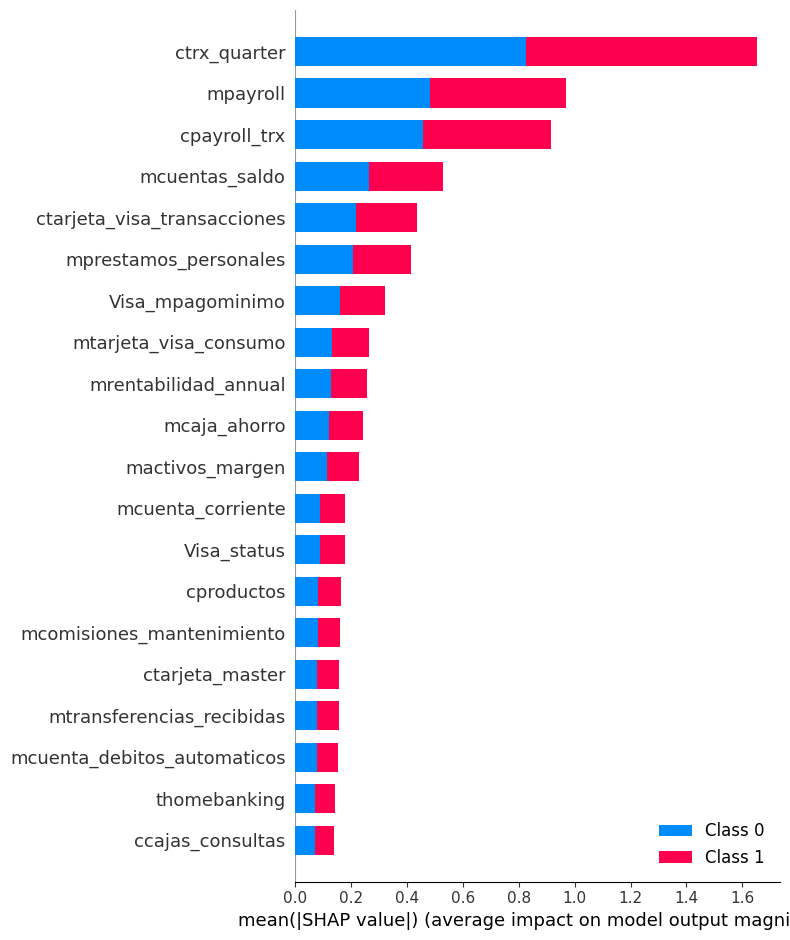

In [14]:
summary_plot = shap.summary_plot(shap_values, Xbajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

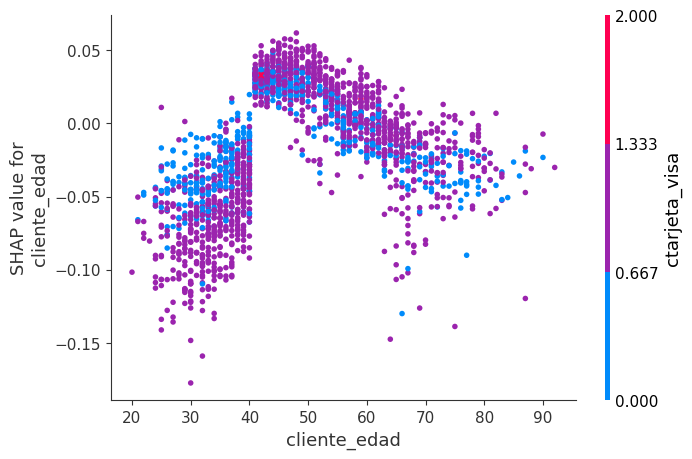

In [15]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

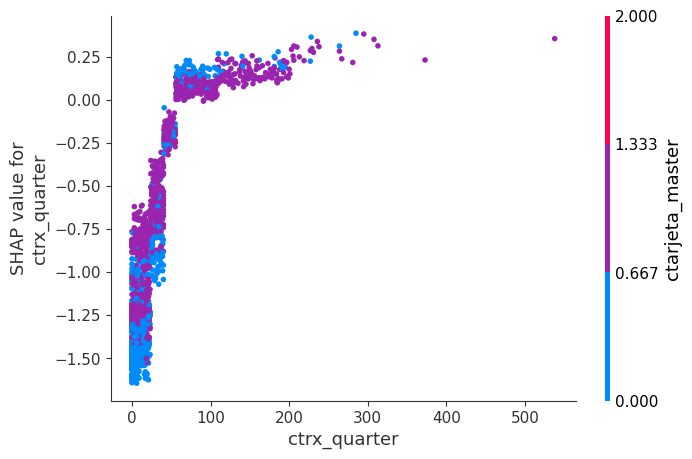

In [16]:
shap.dependence_plot("ctrx_quarter", shap_values[0], Xbajas)

## Clustering

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [17]:
from umap import UMAP
import matplotlib.pyplot as plt


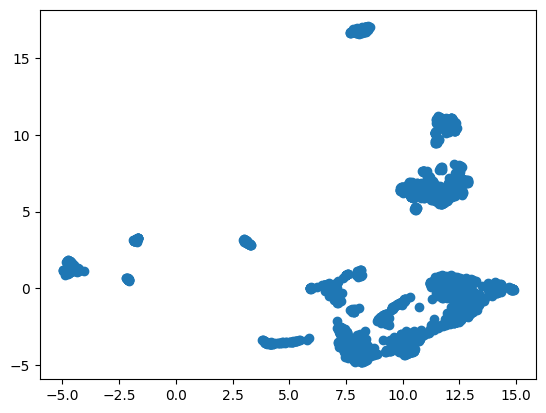

In [18]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=45, random_state=123
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [19]:
embedding_2d.shape

(2013, 2)

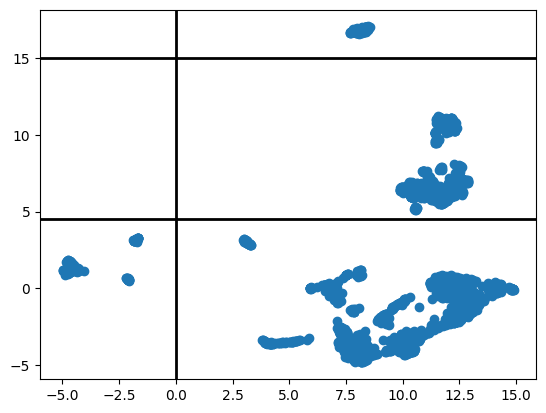

In [20]:
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])
plt.axhline(y=15, linewidth=2, color = 'k')
plt.axvline(x=0, linewidth=2, color = 'k')
plt.axhline(y=4.5, linewidth=2, color = 'k')

In [21]:
df_embedding = pd.DataFrame(embedding_2d, columns=['x', 'y'], index = Xbajas.index)

In [22]:
def set_cluster(row):
    if row['x'] > 0 and row['y'] > 15:
        return 1
    if row['x'] > 0 and row['y'] < 15 and row['y'] > 5:
        return 2
    if row['x'] < 0 and row['y'] < 5:
        return 3
    return 4

In [23]:
df_embedding["cluster"] = df_embedding.apply(lambda row: set_cluster(row), axis = 1)

In [24]:
df_embedding

,x,y,cluster
4050690,11.509895,10.773762,2
4050794,10.684749,-3.117366,4
4050984,7.252672,-3.739435,4
4051198,7.716024,-1.414472,4
4051387,12.386160,6.901359,2
...,...,...,...
4213695,12.764540,-1.252688,4
4213904,10.340761,6.898335,2
4214146,12.383749,-1.095193,4
4214285,13.289293,-1.097358,4


In [25]:
Xbajas = Xbajas.join(df_embedding["cluster"])

In [26]:
Xbajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,cluster
4050690,31162765,202105,1,0,0,63,324,3892.67,42438.85,3147.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4050794,31223039,202105,1,0,0,60,324,2441.50,21395.73,1731.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4050984,31351887,202105,1,0,0,74,324,-10548.12,-41043.44,3364.32,...,12.0,54588.10,-59906.96,17.79,9224.0,35290.47,12.0,0.0,11366.37,4
4051198,31495401,202105,1,0,0,60,209,-79.41,14920.54,2469.09,...,12.0,11157.83,-35518.51,0.00,5863.0,10732.80,7.0,0.0,3777.06,4
4051387,31625364,202105,1,0,0,63,72,3157.25,24147.98,2866.83,...,5.0,0.00,NaN,NaN,2190.0,NaN,NaN,NaN,0.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213695,208266612,202105,1,0,0,46,8,-5475.63,-12933.53,0.00,...,5.0,0.00,-5173.10,0.00,222.0,0.00,0.0,0.0,574.77,4
4213904,209952469,202105,0,0,0,73,6,154.40,1550.48,0.00,...,5.0,0.00,NaN,NaN,165.0,NaN,NaN,NaN,0.00,2
4214146,212188655,202105,1,0,0,31,3,152.73,816.88,71.61,...,5.0,0.00,NaN,NaN,47.0,NaN,NaN,NaN,0.00,4
4214285,212659672,202105,0,0,0,66,2,0.00,0.00,0.00,...,5.0,0.00,NaN,NaN,47.0,NaN,NaN,NaN,0.00,4


In [27]:
Xbajas.groupby(['cluster']).size()

cluster
1      88
2     550
3     155
4    1220
dtype: int64

In [28]:
Xbajas[Xbajas['cluster'] == 1]

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,cluster
4056182,34651286,202105,1,0,1,85,73,23.75,9446.97,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4057751,35635423,202105,0,0,0,70,46,2462.22,25099.27,2089.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4061457,37958629,202105,1,0,0,49,310,2369.97,26998.41,1679.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4062849,38787232,202105,1,0,1,72,324,648.36,24737.11,83.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4064455,39810177,202105,0,0,0,69,287,302.03,31812.85,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206519,180656030,202105,1,0,1,49,34,-3331.83,64052.35,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4208982,192626833,202105,1,0,0,37,25,-492.08,-14458.70,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4209965,194305199,202105,1,0,0,26,20,418.26,2792.33,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4210986,195434064,202105,0,0,1,24,18,1617.69,6621.25,1592.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [29]:
shap_importancias.index

Index(['ctrx_quarter', 'mpayroll', 'cpayroll_trx', 'mcuentas_saldo',
       'ctarjeta_visa_transacciones', 'mprestamos_personales',
       'Visa_mpagominimo', 'mtarjeta_visa_consumo', 'mrentabilidad_annual',
       'mcaja_ahorro',
       ...
       'cpayroll2_trx', 'ccajas_otras', 'ccajas_depositos',
       'cprestamos_hipotecarios', 'ctarjeta_visa_descuentos',
       'mprestamos_hipotecarios', 'cplazo_fijo', 'mplazo_fijo_pesos',
       'cinversion1', 'mforex_buy'],
      dtype='object', length=154)

## Resumenes

In [30]:
Xbajas.groupby(['cluster']).agg({
    'ctrx_quarter': ['min', 'max', 'mean', 'median'],
    'mcuentas_saldo': ['min', 'max', 'mean', 'median'],
    'mcaja_ahorro': ['min', 'max', 'mean', 'median'],
})

ctrx_quarter                        mcuentas_saldo               \
                 min  max       mean median            min          max   
cluster                                                                   
1                  0   23   5.159091    3.0     -315384.24      1376.89   
2                  0   23   7.694545    6.0     -248130.76     18912.26   
3                  0  189  20.225806    9.0    -1094335.15    919382.92   
4                  0  538  54.704918   39.0    -1777746.61  11041037.59   

                                mcaja_ahorro                            \
                 mean    median          min         max          mean   
cluster                                                                  
1       -16451.174091  -8616.64          0.0     2151.96     53.536818   
2       -13585.749436  -6683.50          0.0   102880.61    512.332582   
3       -24707.272129 -12661.94          0.0   742414.40   9710.708516   
4        52807.082090    576.12          0.0  1976985.88  19594.944795   

                  
          median  
cluster           
1           0.00  
2           0.00  
3           0.00  
4        2124.87

<AxesSubplot: xlabel='cluster'>

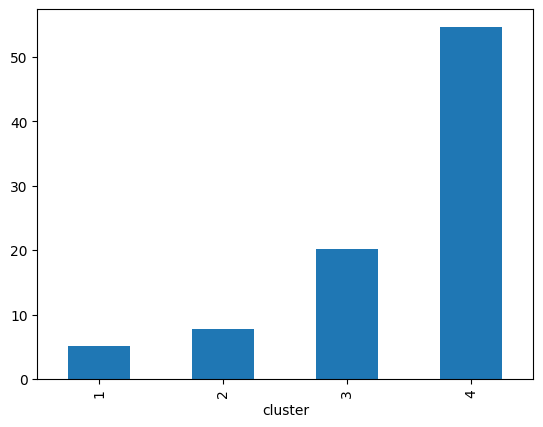

In [31]:
ctrx_quarter = Xbajas.groupby('cluster', as_index=True)["ctrx_quarter"].mean()
ctrx_quarter.plot(kind = "bar")

<AxesSubplot: xlabel='cluster'>

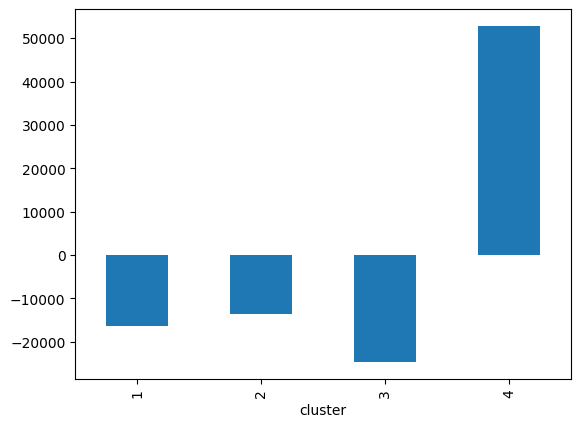

In [32]:
mcuentas_saldo = Xbajas.groupby('cluster', as_index=True)["mcuentas_saldo"].mean()
mcuentas_saldo.plot(kind = "bar")

<AxesSubplot: xlabel='cluster'>

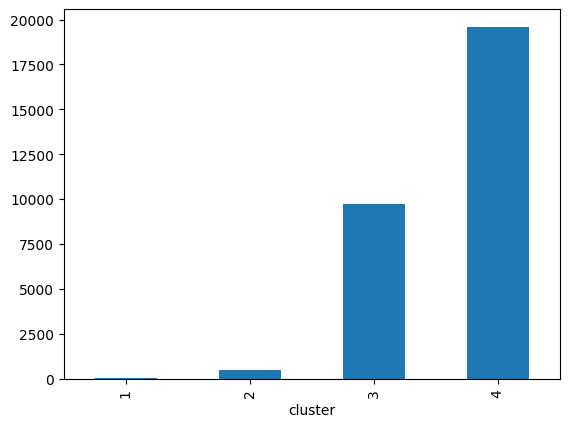

In [33]:
mcaja_ahorro = Xbajas.groupby('cluster', as_index=True)["mcaja_ahorro"].mean()
mcaja_ahorro.plot(kind = "bar")

In [31]:
Xbajas.groupby(['cluster']).agg({
    'mpayroll': ['min', 'max', 'mean', 'median'],
    'cpayroll_trx': ['min', 'max', 'mean', 'median'],
})

mpayroll                                  cpayroll_trx                \
             min         max          mean median          min max      mean   
cluster                                                                        
1            0.0        0.00      0.000000    0.0            0   0  0.000000   
2            0.0    18872.06     34.312836    0.0            0   4  0.007273   
3            0.0    12580.42     85.868774    0.0            0   2  0.025806   
4            0.0  1238776.65  12202.907303    0.0            0  16  0.206557   

                
        median  
cluster         
1          0.0  
2          0.0  
3          0.0  
4          0.0

<AxesSubplot: xlabel='cluster'>

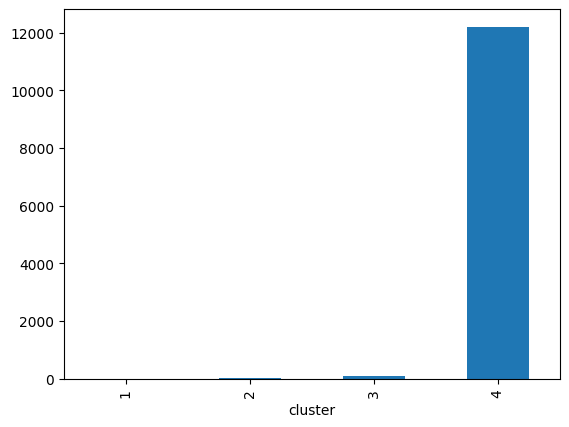

In [34]:
mpayroll = Xbajas.groupby('cluster', as_index=True)["mpayroll"].mean()
mpayroll.plot(kind = "bar")

<AxesSubplot: xlabel='cluster'>

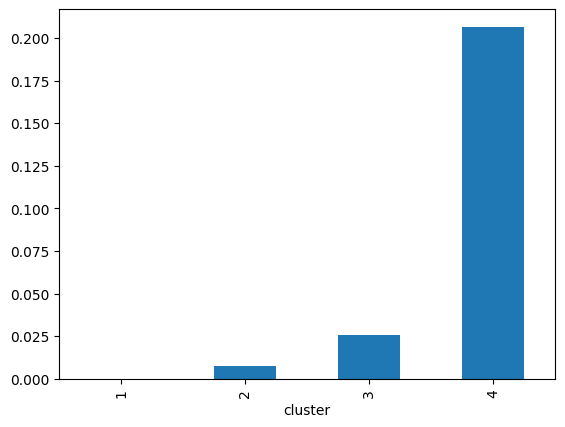

In [35]:
cpayroll_trx = Xbajas.groupby('cluster', as_index=True)["cpayroll_trx"].mean()
cpayroll_trx.plot(kind = "bar")

In [32]:
Xbajas.groupby(['cluster']).agg({
    'ctarjeta_visa_transacciones': ['min', 'max', 'mean', 'median'],
    'Visa_mpagominimo': ['min', 'max', 'mean', 'median'],
    'mtarjeta_visa_consumo': ['min', 'max', 'mean', 'median'],
})

ctarjeta_visa_transacciones                      Visa_mpagominimo  \
                                min max      mean median              min   
cluster                                                                     
1                                 0   0  0.000000    0.0              0.0   
2                                 0  11  0.692727    0.0              0.0   
3                                 0   0  0.000000    0.0              0.0   
4                                 0  95  5.590164    1.5              0.0   

                                           mtarjeta_visa_consumo             \
                max          mean   median                   min        max   
cluster                                                                       
1          11354.64   5677.320000  5677.32                   0.0       0.00   
2         170214.03   1321.202893     0.00                   0.0  810033.97   
3        1686351.72  83076.930387   293.25                   0.0       0.00   
4         756338.67   4177.133946   363.63                   0.0  610419.07   

                                 
                 mean    median  
cluster                          
1            0.000000     0.000  
2         3688.516527     0.000  
3            0.000000     0.000  
4        13973.348041  2164.565

<AxesSubplot: xlabel='cluster'>

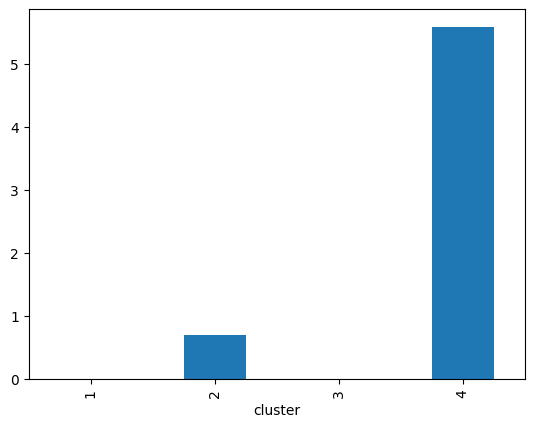

In [36]:
ctarjeta_visa_transacciones = Xbajas.groupby('cluster', as_index=True)["ctarjeta_visa_transacciones"].mean()
ctarjeta_visa_transacciones.plot(kind = "bar")

<AxesSubplot: xlabel='cluster'>

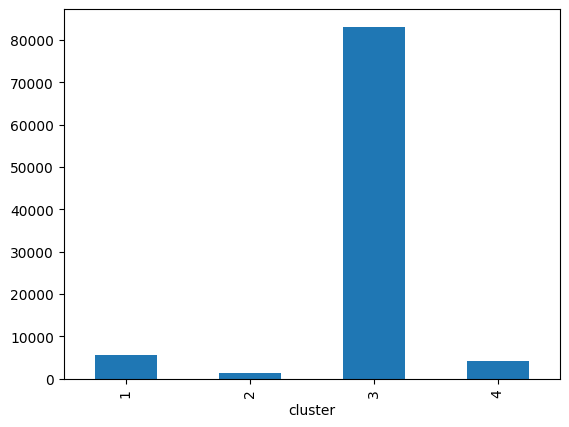

In [37]:
Visa_mpagominimo = Xbajas.groupby('cluster', as_index=True)["Visa_mpagominimo"].mean()
Visa_mpagominimo.plot(kind = "bar")

<AxesSubplot: xlabel='cluster'>

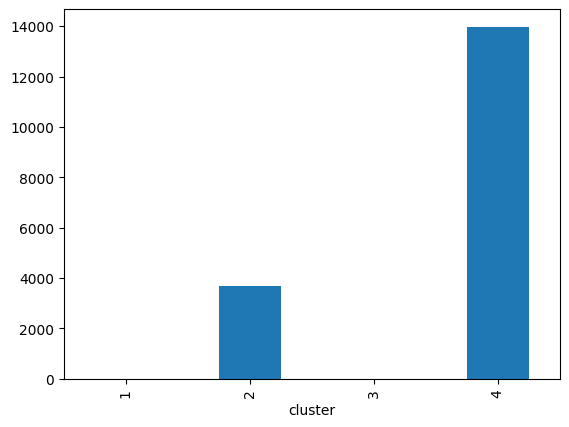

In [38]:
mtarjeta_visa_consumo = Xbajas.groupby('cluster', as_index=True)["mtarjeta_visa_consumo"].mean()
mtarjeta_visa_consumo.plot(kind = "bar")

In [33]:
Xbajas.groupby(['cluster']).agg({
    'mprestamos_personales': ['min', 'max', 'mean', 'median'],
})

mprestamos_personales                                
                          min        max          mean median
cluster                                                      
1                         0.0   16305.23    486.618523    0.0
2                         0.0   19276.27    304.070873    0.0
3                         0.0  112852.72   1134.995484    0.0
4                         0.0  996715.65  12458.935557    0.0

<AxesSubplot: xlabel='cluster'>

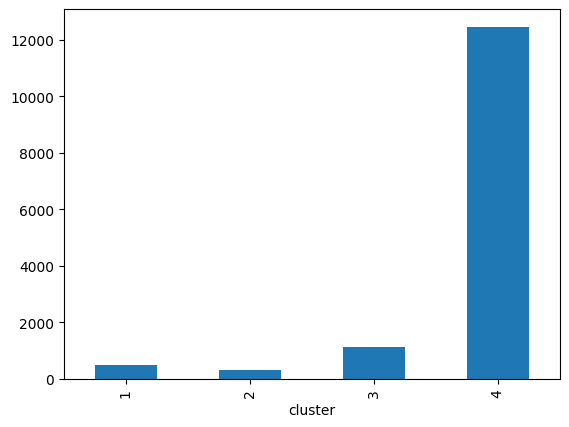

In [39]:
mprestamos_personales = Xbajas.groupby('cluster', as_index=True)["mprestamos_personales"].mean()
mprestamos_personales.plot(kind = "bar")

In [34]:
Xbajas.groupby(['cluster']).agg({
    'mrentabilidad_annual': ['min', 'max', 'mean', 'median'],
})

mrentabilidad_annual                                    
                         min        max          mean     median
cluster                                                         
1                  -14458.70   93773.31  17260.732955  13586.095
2                  -22957.26  919537.76  19424.401509  11797.385
3                 -210278.71  472646.39  32145.851806  17035.020
4                  -79739.57  604232.54  18160.942156   9118.830

<AxesSubplot: xlabel='cluster'>

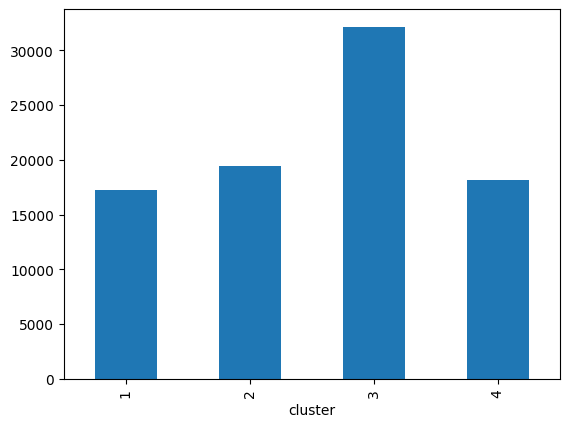

In [40]:
mrentabilidad_annual = Xbajas.groupby('cluster', as_index=True)["mrentabilidad_annual"].mean()
mrentabilidad_annual.plot(kind = "bar")

<AxesSubplot: xlabel='cluster'>

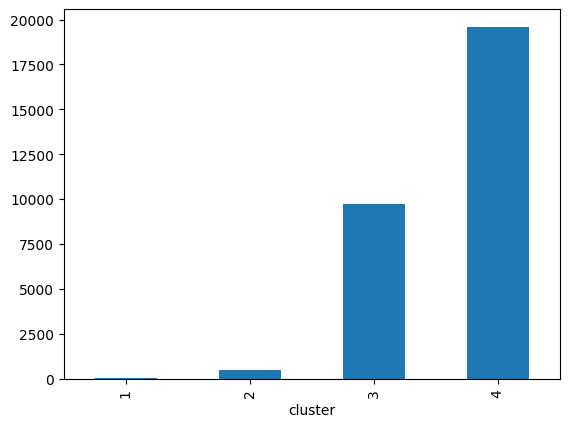

In [41]:
mcaja_ahorro = Xbajas.groupby('cluster', as_index=True)["mcaja_ahorro"].mean()
mcaja_ahorro.plot(kind = "bar")

## shap values por cluster

In [35]:
Xbajas_c1 = Xbajas[Xbajas['cluster'] == 1]
Xbajas_c1 = Xbajas_c1.drop("cluster", axis = 1)

In [36]:
shap_values_c1 = explainer.shap_values(Xbajas_c1)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [37]:
shap_bajas_c1 = pd.DataFrame(shap_values_c1[0], columns = Xbajas_c1.columns)
shap_bajas_c1

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,0.010311,0.0,0.0,0.0,0.002738,-0.026427,-0.001017,0.039021,-0.069452,-0.006759,...,0.0,-0.000215,-0.002103,-0.009347,-0.003447,0.021141,0.0,0.001723,0.0,-0.091120
1,0.011048,0.0,0.0,0.0,-0.005149,-0.023517,-0.030499,-0.044424,0.064609,0.001139,...,0.0,-0.014586,-0.000700,-0.008862,-0.002059,0.014862,0.0,0.000322,0.0,-0.115192
2,0.012019,0.0,0.0,0.0,-0.003940,0.025487,0.016251,-0.044247,0.071315,0.002420,...,0.0,-0.017181,-0.000932,-0.008651,-0.003390,0.017006,0.0,-0.000936,0.0,-0.105377
3,0.011930,0.0,0.0,0.0,0.010370,-0.027257,0.013313,0.024375,0.060155,-0.001975,...,0.0,-0.006928,-0.001925,-0.009779,-0.002002,0.016116,0.0,0.000952,0.0,-0.108868
4,0.011581,0.0,0.0,0.0,-0.004917,-0.029624,0.008832,0.034474,0.081255,-0.001689,...,0.0,-0.006928,-0.001962,-0.009775,-0.002002,0.009582,0.0,0.004080,0.0,-0.117486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,-0.022031,0.0,0.0,0.0,0.011738,0.023176,-0.018562,0.033397,0.062183,-0.009528,...,0.0,-0.003191,-0.001690,-0.007766,-0.002059,0.016991,0.0,0.013713,0.0,-0.109182
84,-0.022159,0.0,0.0,0.0,-0.005499,-0.031971,-0.019573,0.037032,-0.095088,-0.008161,...,0.0,0.001726,-0.001618,-0.007692,-0.002059,0.017713,0.0,0.008588,0.0,-0.094993
85,-0.020007,0.0,0.0,0.0,-0.004869,-0.045038,-0.023037,0.035970,-0.094142,-0.005536,...,0.0,0.002037,-0.001618,-0.007467,-0.002059,0.017949,0.0,0.011219,0.0,-0.097028
86,-0.021287,0.0,0.0,0.0,0.012273,-0.044224,-0.030258,-0.027551,-0.138794,-0.000142,...,0.0,-0.003026,-0.000998,-0.007940,-0.003447,0.019004,0.0,0.009923,0.0,-0.086469


In [38]:
shap_importancias_c1 = shap_bajas_c1.abs().mean().sort_values(ascending=False)
shap_importancias_c1

ctrx_quarter                1.464976
mpayroll                    0.433024
cpayroll_trx                0.422751
mcuentas_saldo              0.366557
cdescubierto_preacordado    0.325324
                              ...   
ccheques_depositados        0.000000
cprestamos_hipotecarios     0.000000
mprestamos_hipotecarios     0.000000
cplazo_fijo                 0.000000
mforex_buy                  0.000000
Length: 154, dtype: float64

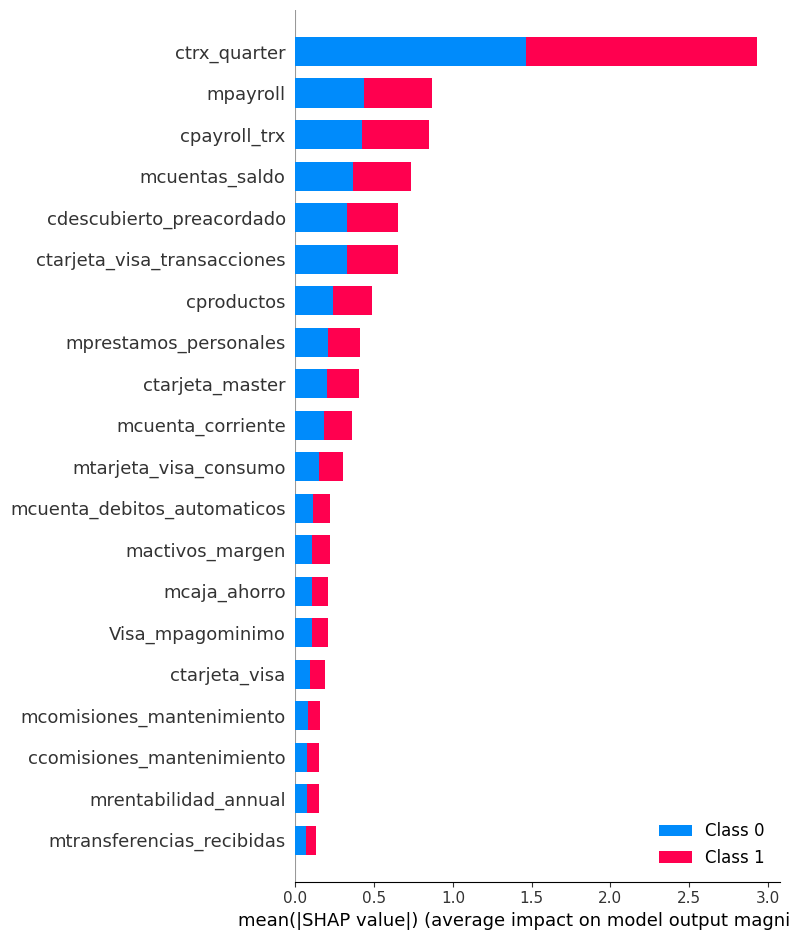

In [39]:
summary_plot = shap.summary_plot(shap_values_c1, Xbajas_c1)

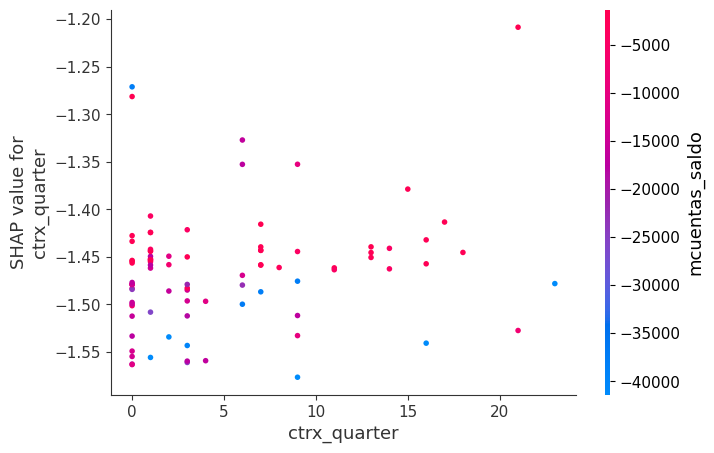

In [40]:
shap.dependence_plot("ctrx_quarter", shap_values_c1[0], Xbajas_c1)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [41]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn_extra.cluster import KMedoids

In [42]:
k = 4
clusterer = KMeans(n_clusters=k, init="random", random_state=100, n_init=100, max_iter=1000, algorithm="elkan")
cluster_labels = clusterer.fit_predict(embedding_2d)
centers = clusterer.cluster_centers_

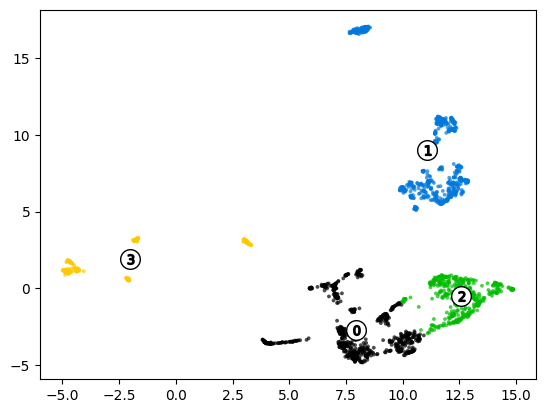

In [43]:
datos = embedding_2d
colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
plt.scatter(
    datos[:, 0], datos[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

In [44]:
k = 4
clusterer = KMedoids(n_clusters=k, random_state=100)
cluster_labels = clusterer.fit_predict(embedding_2d)
centers = clusterer.cluster_centers_

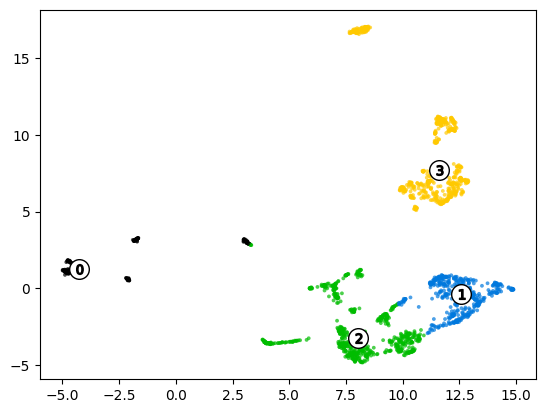

In [45]:
datos = embedding_2d
colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
plt.scatter(
    datos[:, 0], datos[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")